# Import Required data

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


# Clone the Face dataset from GitHub

In [ ]:
# Collect the URL for Fruit dataset
URL_FACE = 'https://github.com/JKJIN1999/Race_Face'

%cd /content
FACE_DIR= os.path.abspath(os.path.join('.', os.path.basename(URL_FACE)))
!git clone {URL_FACE}
%cd {FACE_DIR}
!git pull

/content
Cloning into 'Race_Face'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 554 (delta 325), reused 553 (delta 324), pack-reused 0
Receiving objects: 100% (554/554), 8.37 MiB | 28.39 MiB/s, done.
Resolving deltas: 100% (325/325), done.
/content/Race_Face
Already up to date.


# Set Direction for Train and Test

In [ ]:
base_dir = '/content/Race_Face/data'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

# Create each generator for train, test, and validation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 100x100
        batch_size=32,
        # Using categorical classmode since there are 130 labels
        class_mode='categorical',
        subset='training')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

# Flow test images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 330 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 126 images belonging to 5 classes.


# Check dataset

In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 5))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'African American': 0, 'Caucasian': 1, 'East Asian': 2, 'Hispanic': 3, 'Indian Asian': 4}


# Import MobileNet V2 and freeze every model except the top layer

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False

# Create the model using the MobileNet V2 and additional layers

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compile and check model summary

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 2,626,949
Trainable params: 368,901
Non-trainable params: 2,258,048
______________________________________

# Train the Model

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=20, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator))

Epoch 1/20
11/11 [==============================] - 7s 611ms/step - loss: 1.4299 - accuracy: 0.5242 - val_loss: 2.3733 - val_accuracy: 0.4875
Epoch 2/20
11/11 [==============================] - 6s 514ms/step - loss: 0.7462 - accuracy: 0.7303 - val_loss: 1.6148 - val_accuracy: 0.7125
Epoch 3/20
11/11 [==============================] - 6s 513ms/step - loss: 0.6739 - accuracy: 0.7545 - val_loss: 1.1706 - val_accuracy: 0.7000
Epoch 4/20
11/11 [==============================] - 6s 511ms/step - loss: 0.6279 - accuracy: 0.7667 - val_loss: 1.1014 - val_accuracy: 0.7000
Epoch 5/20
11/11 [==============================] - 6s 508ms/step - loss: 0.5330 - accuracy: 0.8152 - val_loss: 1.0469 - val_accuracy: 0.7125
Epoch 6/20
11/11 [==============================] - 6s 508ms/step - loss: 0.4407 - accuracy: 0.8333 - val_loss: 0.9210 - val_accuracy: 0.7000
Epoch 7/20
11/11 [==============================] - 6s 589ms/step - loss: 0.3902 - accuracy: 0.8667 - val_loss: 0.7301 - val_accuracy: 0.7875
Epoch 

# For Fine Tuning, unfreeze ONLY the top layer

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = len(base_model.layers)

Number of layers in the base model:  155


In [ ]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile the model with using much lower training rate

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 2,626,949
Trainable params: 368,901
Non-trainable params: 2,258,048
______________________________________

# Train the model once again

In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=10, 
                         validation_data=validation_generator, 
                         validation_steps=len(validation_generator))

Epoch 1/10
11/11 [==============================] - 7s 630ms/step - loss: 0.2197 - accuracy: 0.9182 - val_loss: 1.1178 - val_accuracy: 0.7375
Epoch 2/10
11/11 [==============================] - 6s 544ms/step - loss: 0.2479 - accuracy: 0.9182 - val_loss: 0.9569 - val_accuracy: 0.6625
Epoch 3/10
11/11 [==============================] - 6s 534ms/step - loss: 0.2420 - accuracy: 0.9242 - val_loss: 0.8489 - val_accuracy: 0.7250
Epoch 4/10
11/11 [==============================] - 6s 534ms/step - loss: 0.2067 - accuracy: 0.9152 - val_loss: 0.8523 - val_accuracy: 0.6500
Epoch 5/10
11/11 [==============================] - 6s 512ms/step - loss: 0.2337 - accuracy: 0.9303 - val_loss: 0.9890 - val_accuracy: 0.7750
Epoch 6/10
11/11 [==============================] - 6s 535ms/step - loss: 0.2356 - accuracy: 0.9303 - val_loss: 0.8710 - val_accuracy: 0.7250
Epoch 7/10
11/11 [==============================] - 6s 516ms/step - loss: 0.2051 - accuracy: 0.9455 - val_loss: 0.8379 - val_accuracy: 0.7125
Epoch 

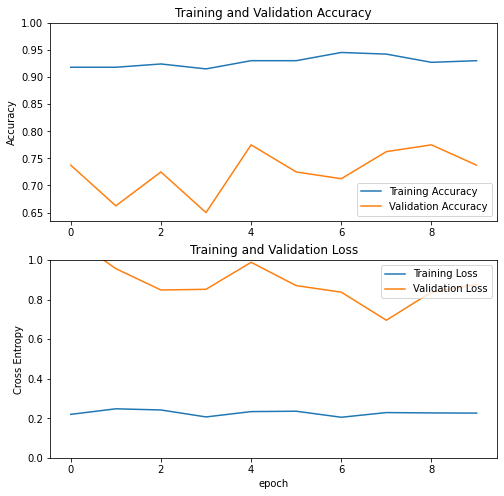

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

model.evaluate(test_generator)

4/4 [==============================] - 1s 184ms/step - loss: 0.7362 - accuracy: 0.7381


[0.7361730337142944, 0.738095223903656]

# Convert the model into TFLite

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


**Download the TFLite model and labels**

In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')